In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [74]:
params = []
for path in sorted(glob.glob("../../../../logs/lions-maxtwo**-2019-06-14*/**/rep00/", recursive=True) + glob.glob("../../../../logs/lions-maxtwo**-2019-06-15*/**/rep00/", recursive=True)):
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    params.append((path, readparams(glob.glob(path + 'properties*')[0]), logall.query('nbOnOpp == 2')['curCoopNoCoef'].mean()))

diffkeys = []
for key in params[0][1].keys():
    if any(params[i][1][key] != params[0][1][key] for i in range(1, len(params))):
        diffkeys.append(key)

In [75]:
df.head()

,b,coop,fakeCoef,gInitialNumberOfRobots,gNbOfPhysicalObjects,gRandomSeed,oppDecay
0,10.0,-0.028028,0.1,100.0,120.0,2.117656e+09,1000.0
1,10.0,-0.017463,0.1,100.0,120.0,2.117656e+09,1000.0
2,10.0,0.160710,0.1,100.0,120.0,-2.080186e+08,500.0
3,10.0,-0.027194,0.1,100.0,120.0,-2.080171e+08,500.0
4,3.0,-0.042472,0.1,100.0,120.0,-2.064171e+09,1000.0


In [76]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem[1]
    ess = param['meanA'] / 2
    so = param['meanA'] + param['b'] / 2
    outdict = {'coop': (elem[2] - ess) / (so - ess) }
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem[1][key]
    processed.append(outdict)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

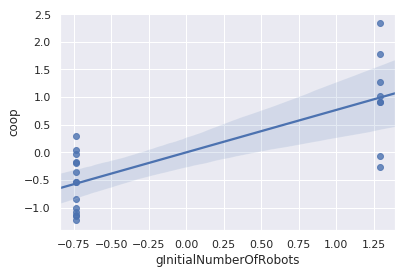

In [77]:
sns.regplot(x='gInitialNumberOfRobots', y='coop', data=normalized_df)

In [78]:
import statsmodels.formula.api as sm

In [79]:
result = sm.ols(formula="coop ~ gInitialNumberOfRobots + b + oppDecay + fakeCoef", data=normalized_df).fit()

In [80]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   coop   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     7.196
Date:                Tue, 18 Jun 2019   Prob (F-statistic):            0.00140
Time:                        18:02:27   Log-Likelihood:                -19.807
No. Observations:                  22   AIC:                             49.61
Df Residuals:                      17   BIC:                             55.07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -7.633e-17      0.144  -5.29e-16      1.000      -0.305       0.305
gInitialNumberOfRobots     0.8676      0.167      5.204      0.000       0.516       1.219
b                         -0.0403      0.161     -0.251      0.805      -0.379       0.299
oppDecay                  -0.0415      0.150     -0.277      0.785      -0.357       0.274
fakeCoef                   0.2391      0.179      1.333      0.200      -0.139       0.617
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.027
Skew:                           0.029   Prob(JB):                        0.987
Kurtosis:                       2.840   Cond. No.                         1.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""